In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')

In [4]:
print(df.columns)

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [5]:
group_cols = {
    'Frequency': ['Order Id'],  
    'Severity': ['Sales per customer', 'Order Item Quantity', 'Order Item Product Price'],
    'LeadTime': ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']
}

In [6]:
df_grouped = df.groupby('Customer Id').agg({
    'Order Id': 'count',
    'Sales per customer': 'mean',
    'Order Item Quantity': 'mean',
    'Order Item Product Price': 'mean',
    'Days for shipping (real)': 'mean',
    'Days for shipment (scheduled)': 'mean',
    'Order Item Total': 'mean'
}).rename(columns={'Order Id': 'Order Count'})

In [7]:
scaler = MinMaxScaler()
norm_features = ['Order Count', 'Sales per customer', 'Order Item Quantity', 'Order Item Product Price',
                 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']

In [8]:
df_norm = df_grouped.copy()
df_norm[norm_features] = scaler.fit_transform(df_norm[norm_features])

In [9]:
df_norm['F_norm'] = df_norm['Order Count']
df_norm['S_norm'] = df_norm[['Sales per customer', 'Order Item Quantity', 'Order Item Product Price']].mean(axis=1)
df_norm['L_norm'] = df_norm[['Days for shipping (real)', 'Days for shipment (scheduled)', 'Order Item Total']].mean(axis=1)

In [10]:
X = df_norm[['F_norm', 'S_norm', 'L_norm']]
pca = PCA(n_components=3)
pca.fit(X)
pca_weights = pca.explained_variance_ratio_
pca_weights /= pca_weights.sum()

In [11]:
equal_weights = np.array([1/3, 1/3, 1/3])

In [12]:
heuristic_weights = np.array([0.4, 0.35, 0.25])

In [13]:
df_norm['SCRI_heuristic'] = X.dot(heuristic_weights)
df_norm['SCRI_pca'] = X.dot(pca_weights)
df_norm['SCRI_equal'] = X.dot(equal_weights)

In [14]:
df_norm['Rank_heuristic'] = df_norm['SCRI_heuristic'].rank(ascending=True)
df_norm['Rank_pca'] = df_norm['SCRI_pca'].rank(ascending=True)
df_norm['Rank_equal'] = df_norm['SCRI_equal'].rank(ascending=True)

In [15]:
output_cols = ['F_norm', 'S_norm', 'L_norm',
               'SCRI_heuristic', 'SCRI_pca', 'SCRI_equal',
               'Rank_heuristic', 'Rank_pca', 'Rank_equal']

In [16]:
df_norm[output_cols].to_csv('scri_results.csv')

In [17]:
print("SCRI computation complete!")
print("Output saved to scri_results.csv")
print("\nWeights used:")
print(f"Heuristic Weights: F=0.4, S=0.35, L=0.25")
print("PCA-derived Weights:", np.round(pca_weights, 3))
print("Equal-risk Weights:", np.round(equal_weights, 3))

SCRI computation complete!
Output saved to scri_results.csv

Weights used:
Heuristic Weights: F=0.4, S=0.35, L=0.25
PCA-derived Weights: [0.527 0.352 0.121]
Equal-risk Weights: [0.333 0.333 0.333]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from scipy.special import logit
import numpy as np

In [10]:
def calibration_slope_intercept(y_true, y_prob):
    eps = 1e-15
    y_prob = np.clip(y_prob, eps, 1 - eps)  # avoid logit inf
    logit_preds = logit(y_prob).reshape(-1, 1)
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit_preds, y_true)
    return lr.coef_[0][0], lr.intercept_[0]

In [11]:
df = pd.read_csv("scri_results.csv")

In [12]:
f_thresh = df['F_norm'].quantile(0.50)
s_thresh = df['S_norm'].quantile(0.50)
df['label'] = ((df['F_norm'] >= f_thresh) & (df['S_norm'] >= s_thresh)).astype(int)

y_true = df['label']

=== SCRI_heuristic ===
ROC-AUC: 0.8620
PR-AUC: 0.6541
Brier score: 0.1940
Raw calibration slope=16.8056, intercept=-4.9925
Platt-calibrated slope=1.0680, intercept=0.0311
Isotonic-calibrated slope=0.9997, intercept=0.0003
--------------------------------------------------


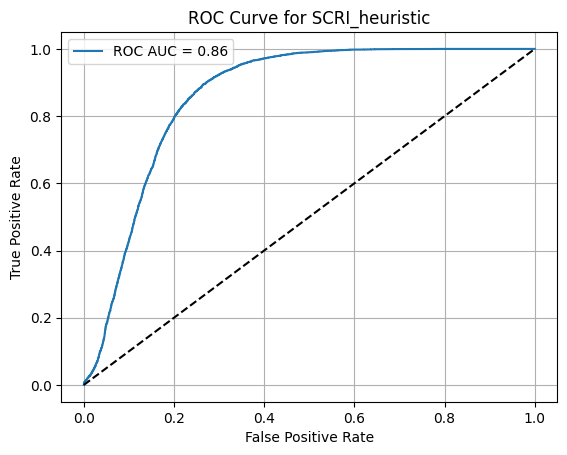

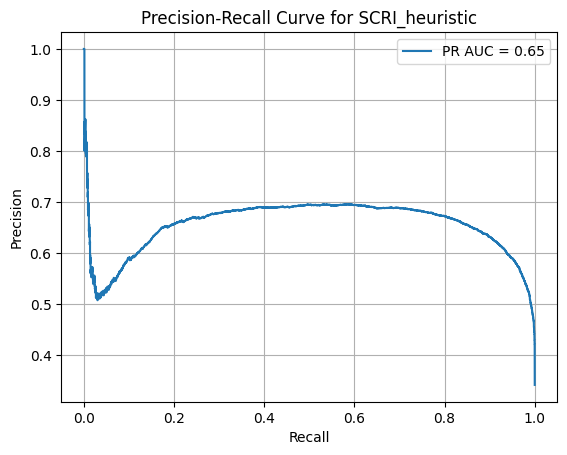

=== SCRI_pca ===
ROC-AUC: 0.8798
PR-AUC: 0.7079
Brier score: 0.1929
Raw calibration slope=16.3199, intercept=-4.2474
Platt-calibrated slope=1.0551, intercept=0.0238
Isotonic-calibrated slope=0.9998, intercept=0.0006
--------------------------------------------------


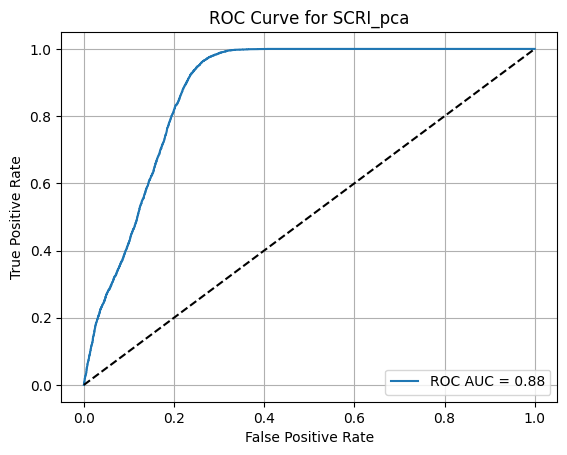

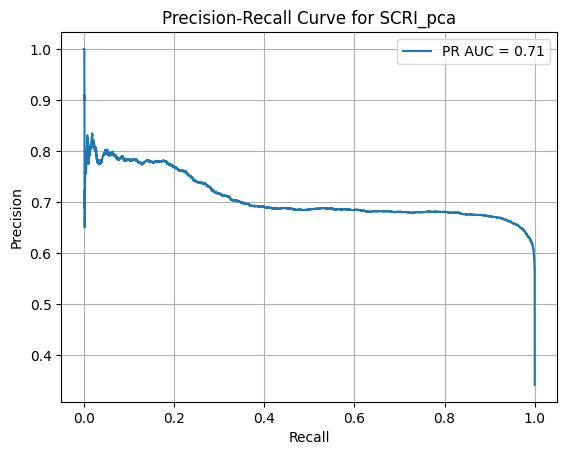

=== SCRI_equal ===
ROC-AUC: 0.8341
PR-AUC: 0.6152
Brier score: 0.1963
Raw calibration slope=15.3571, intercept=-5.0013
Platt-calibrated slope=1.0695, intercept=0.0335
Isotonic-calibrated slope=0.9997, intercept=-0.0000
--------------------------------------------------


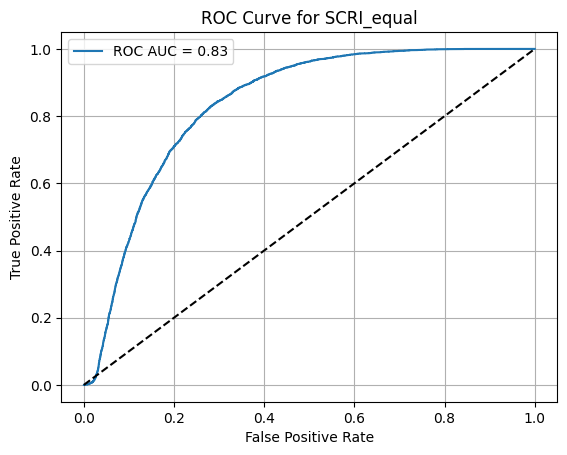

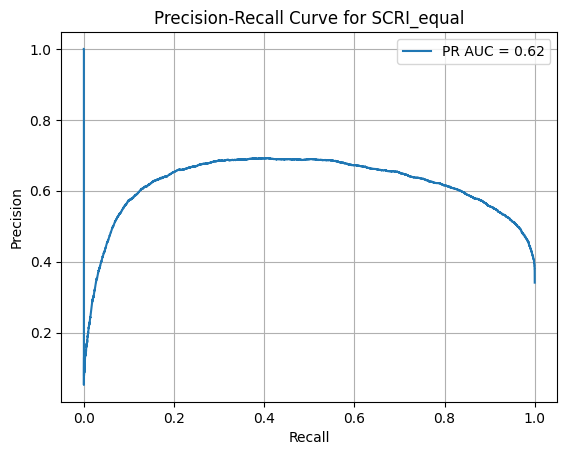

In [13]:
calibrated_scores = {}

for col in ['SCRI_heuristic', 'SCRI_pca', 'SCRI_equal']:
    y_scores = df[col]

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Brier score
    brier = brier_score_loss(y_true, y_scores)

    # Raw calibration slope & intercept
    lr_raw = LogisticRegression(solver="lbfgs")
    lr_raw.fit(y_scores.values.reshape(-1, 1), y_true)
    slope_raw = lr_raw.coef_[0][0]
    intercept_raw = lr_raw.intercept_[0]

    # --- Platt scaling (logistic calibration)
    lr_cal = LogisticRegression(solver="lbfgs")
    lr_cal.fit(y_scores.values.reshape(-1, 1), y_true)
    y_platt = lr_cal.predict_proba(y_scores.values.reshape(-1, 1))[:, 1]
    slope_platt, intercept_platt = calibration_slope_intercept(y_true, y_platt)

    # --- Isotonic regression
    iso_cal = IsotonicRegression(out_of_bounds="clip")
    y_iso = iso_cal.fit_transform(y_scores, y_true)
    slope_iso, intercept_iso = calibration_slope_intercept(y_true, y_iso)

    # Save calibrated outputs
    calibrated_scores[col] = {"platt": y_platt, "iso": y_iso}

    # Print metrics
    print(f"=== {col} ===")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Brier score: {brier:.4f}")
    print(f"Raw calibration slope={slope_raw:.4f}, intercept={intercept_raw:.4f}")
    print(f"Platt-calibrated slope={slope_platt:.4f}, intercept={intercept_platt:.4f}")
    print(f"Isotonic-calibrated slope={slope_iso:.4f}, intercept={intercept_iso:.4f}")
    print("-" * 50)

    # --- Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve for {col}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot PR
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.title(f'Precision-Recall Curve for {col}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()


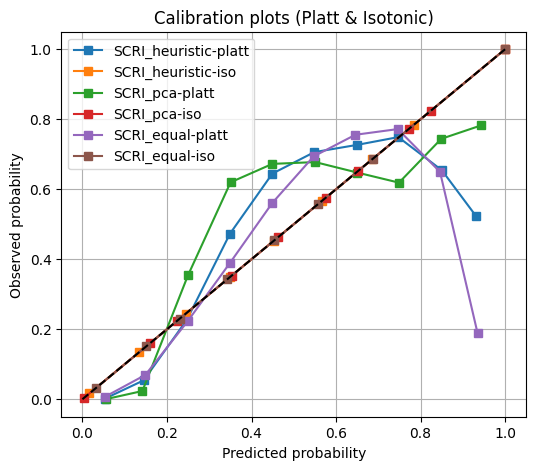

In [14]:
plt.figure(figsize=(6, 5))
for col in ['SCRI_heuristic', 'SCRI_pca', 'SCRI_equal']:
    for method in ['platt', 'iso']:
        prob_true, prob_pred = calibration_curve(y_true, calibrated_scores[col][method], n_bins=10)
        plt.plot(prob_pred, prob_true, "s-", label=f"{col}-{method}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration plots (Platt & Isotonic)")
plt.legend()
plt.grid(True)
plt.show()